# Prédiction de l'état de santé (`is_healthy`)

Objectif : construire et analyser un modèle de Machine Learning qui prédit la variable binaire **`is_healthy`** à partir de caractéristiques liées au profil, à l’activité physique et à l’alimentation.

Dans ce notebook, on va :
1. Explorer rapidement les données (distribution de la cible, corrélations).
2. Préparer les variables explicatives (features) et la cible.
3. Tester plusieurs modèles (Logistic Regression, KNN, Decision Tree, Random Forest, SVM).
4. Sélectionner un **meilleur modèle** et analyser ses performances.
5. Interpréter les résultats de manière simple et compréhensible.


In [212]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style='whitegrid', palette='pastel')
np.random.seed(42)


### Imports & configuration

In [213]:

new_data = pd.read_csv('Newdata.csv', encoding='ascii', delimiter=',')
print('Newdata.csv shape:', new_data.shape)


Newdata.csv shape: (20000, 53)


## 1. Aperçu rapide des données

On regarde les premières lignes, les types de variables et un résumé statistique pour comprendre la structure du dataset.


In [214]:
display(new_data.head())


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,Lateral raises,23.479709,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,Incline dumbbell flyes,32.449827,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176


## 2. Analyse de la variable cible `is_healthy`

On vérifie :
- la distribution des classes (0 vs 1),
- le pourcentage de personnes `healthy` vs `unhealthy`.

C’est important pour savoir si les classes sont équilibrées ou non.



Pourcentages par classe (%):
is_healthy
0    92.76
1     7.24
Name: count, dtype: float64


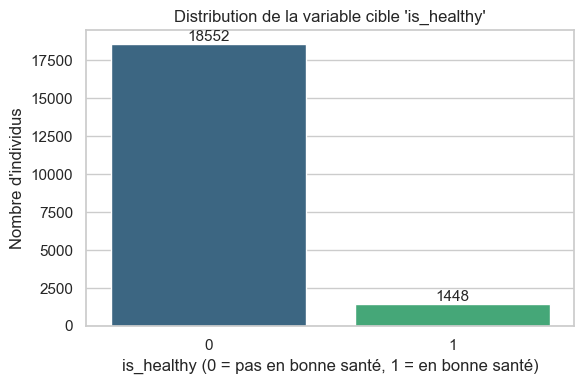

In [275]:
# S'assurer que la cible est bien de type entier
new_data['is_healthy'] = new_data['is_healthy'].astype(int)

target_counts = new_data['is_healthy'].value_counts().sort_index()
target_percent = 100 * target_counts / len(new_data)

print("\nPourcentages par classe (%):")
print(target_percent)

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='is_healthy', data=new_data, palette="viridis")

# Ajouter les valeurs exactes sur les barres
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f"{count}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=11)

plt.title("Distribution de la variable cible 'is_healthy'")
plt.xlabel("is_healthy (0 = pas en bonne santé, 1 = en bonne santé)")
plt.ylabel("Nombre d'individus")
plt.tight_layout()
plt.show()


### Interpretation
La cible is_healthy est extrêmement déséquilibrée :
18 552 personnes ne sont pas healthy (classe 0)
1 448 seulement sont healthy (classe 1)
Ainsi, plus de 92 % des individus appartiennent à la classe 0.


## 3. Description des variables et nettoyage

Ici on :
- liste les variables explicatives potentielles,
- vérifie les valeurs manquantes,
- décide si certaines colonnes doivent être exclues (ID, colonnes constantes, etc.),
- prépare une liste de features à utiliser dans les modèles.


In [279]:
# Petite table descriptive des variables
variables_info = pd.DataFrame({
    "colonne": new_data.columns,
    "dtype": new_data.dtypes.values,
    "nb_na": new_data.isna().sum().values
})
print("Lignes vides : ", variables_info['nb_na'].sum())



Lignes vides :  0


## 4. Corrélation des variables numériques avec `is_healthy`

On regarde quelles variables numériques sont le plus liées à la cible.  
Cela donne une première idée des facteurs importants.


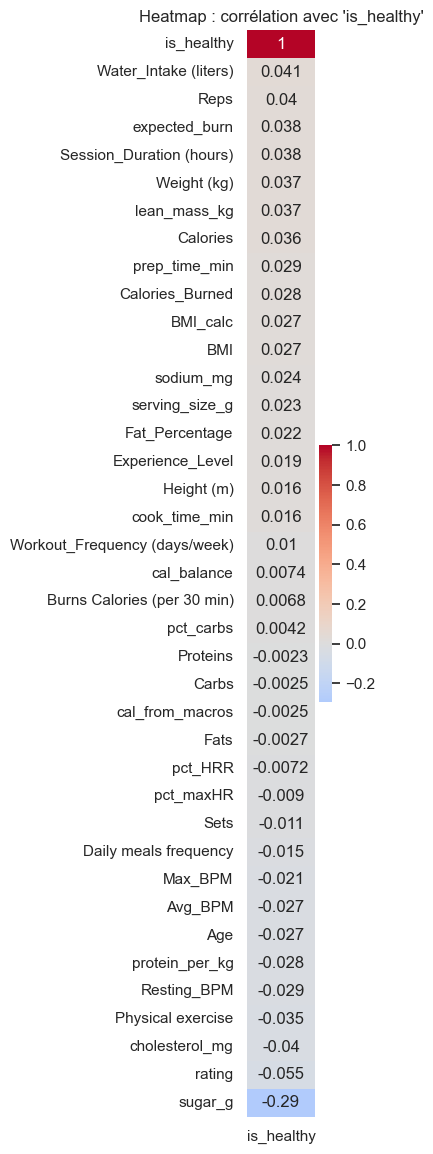

In [290]:
numeric_df = new_data.select_dtypes(include=['number'])

corr_target = numeric_df.corr()['is_healthy'].sort_values(ascending=False)


# Heatmap ciblée
plt.figure(figsize=(4, len(corr_target) * 0.3 ))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap : corrélation avec 'is_healthy'")
plt.tight_layout()
plt.show()


Index(['sugar_g', 'rating', 'cholesterol_mg', 'Water_Intake (liters)',
       'Weight (kg)', 'lean_mass_kg', 'Calories', 'Reps', 'expected_burn',
       'Session_Duration (hours)'],
      dtype='object')


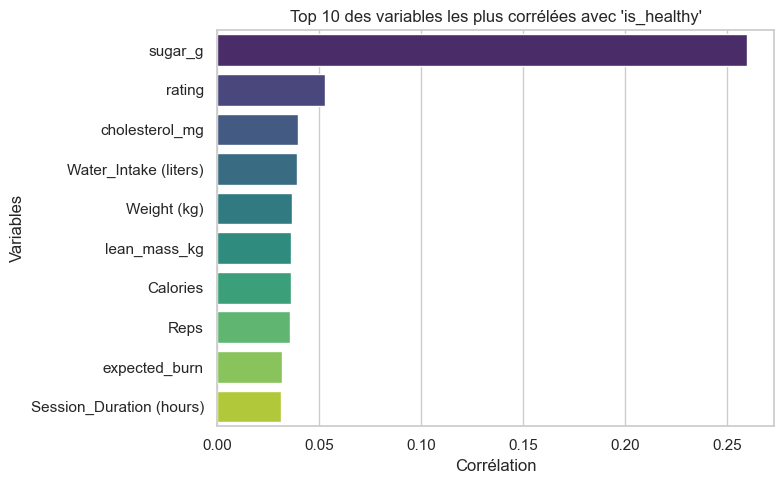

In [218]:
# Calcul des corrélations numériques
corr = numeric_df.corr()['is_healthy'].drop('is_healthy')

# Sélection du top 5 en valeur absolue
top10 = corr.abs().sort_values(ascending=False).head(10)
top10_names = top10.index
print(top10_names)
# On récupère les valeurs "signées" pour le graphique
top10_signed = corr[top10_names].abs()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top10_signed.values,
    y=top10_signed.index,
    palette="viridis"
)

plt.title("Top 10 des variables les plus corrélées avec 'is_healthy'")
plt.xlabel("Corrélation")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


## 5. Construction de `X` (features) et `y` (cible)

On choisit les variables explicatives utilisées pour la prédiction.

Ici, on se base sur les variables numériques du dataset (et éventuellement quelques variables pertinentes si elles sont non numériques).


In [230]:
features = ['sugar_g','rating','cholesterol_mg','Water_Intake (liters)','Weight (kg)',
            'lean_mass_kg','Calories','Reps','expected_burn','Session_Duration (hours)']



X = new_data[features]


y = new_data['is_healthy'].astype(int)



## 6. Séparation train / test

On sépare les données en :
- **train** (pour entraîner les modèles),
- **test** (pour évaluer les performances finales).

On utilise un split **stratifié** pour garder la proportion de `is_healthy` dans chaque sous-échantillon. Comme on a vu en cours, 20% pour les tests, et 80% pour l'entrainement.


In [231]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)


Taille X_train : (16000, 10)
Taille X_test  : (4000, 10)


In [232]:
numeric_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)


## 7. Benchmark de plusieurs modèles

On compare plusieurs algorithmes :

- Régression logistique
- k-Plus Proches Voisins (KNN)
- Arbre de décision
- SVM (RBF)

Pour chaque modèle :
- Validation croisée (5 folds) sur le train
- Score moyen + écart-type
- Score final sur le test


### Définition des modèles + validation croisée

In [233]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', model)
    ])
    
    # Validation croisée sur le train
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Entraînement final sur le train + score test
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    results.append({
        "Model": name,
        "CV_accuracy_mean": cv_scores.mean(),
        "CV_accuracy_std": cv_scores.std(),
        "Test_accuracy": test_acc
    })

results_df = pd.DataFrame(results).sort_values(by="Test_accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,CV_accuracy_mean,CV_accuracy_std,Test_accuracy
0,KNN,0.982875,0.001805,0.98175
1,RandomForest,0.979625,0.001072,0.97800
2,DecisionTree,0.970063,0.002961,0.96800
3,SVM_RBF,0.932625,0.001212,0.93875
4,LogReg,0.927625,0.000250,0.92875


### Interprétation rapide

- **CV_accuracy_mean** : performance moyenne en validation croisée sur les données d’entraînement.
- **Test_accuracy** : performance finale sur les données de test (jamais vues pendant l’entraînement).

Le **meilleur modèle** est celui qui combine :
- une bonne performance en CV,
- une bonne performance sur le test,
- et un écart raisonnable entre les deux (pour éviter l’overfitting).

Dans la suite, on va se concentrer sur le **meilleur modèle** : on note ici que c'est le KNN.


## 8. Analyse détaillée du meilleur modèle (KNN)

On va maintenant se concentrer sur le **K-Plus Proches Voisins (KNN)**, qui est le meilleur modèle sur nos données.

Le principe du KNN est simple :
- pour prédire si une personne est en bonne santé ou non,
- le modèle regarde les **K individus les plus “proches”** dans les données,
- et il prend la **classe majoritaire** parmi ces voisins.

Dans cette section, on va :
1. Entraîner un modèle KNN sur les données d'entraînement.
2. Évaluer ses performances sur les données de test.
3. Visualiser la matrice de confusion.
4. Tracer la courbe ROC.
5. Regarder quelles variables semblent les plus importantes via une importance par permutation (approximation).


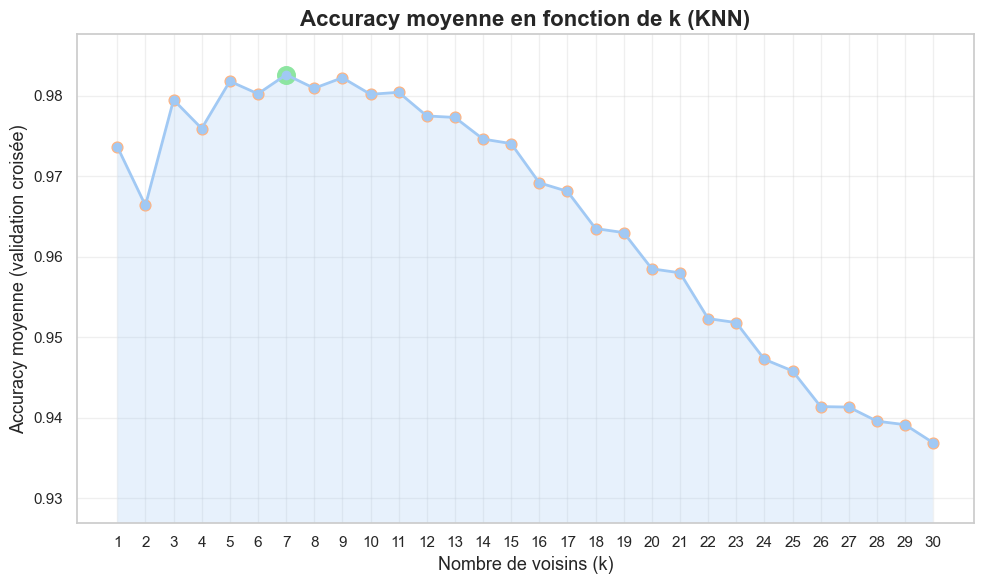

In [234]:
plt.figure(figsize=(10, 6))

# On trie les résultats par k pour être sûr que tout est dans l'ordre
df_plot = cv_results_df.sort_values("k")

k_vals = df_plot["k"].values
acc_vals = df_plot["cv_mean_accuracy"].values

# Zone remplie (area plot)
plt.fill_between(k_vals, acc_vals, alpha=0.25)

# Courbe + points
plt.plot(k_vals, acc_vals, marker="o", linewidth=2)
plt.scatter(k_vals, acc_vals, s=60)

# Meilleur k (d'après cv_results_df, peu importe l'ordre)
best_row = cv_results_df.loc[cv_results_df["cv_mean_accuracy"].idxmax()]
best_k = int(best_row["k"])
best_acc = best_row["cv_mean_accuracy"]

plt.scatter([best_k], [best_acc], s=160)


plt.title("Accuracy moyenne en fonction de k (KNN)", fontsize=16, fontweight="bold")
plt.xlabel("Nombre de voisins (k)", fontsize=13)
plt.ylabel("Accuracy moyenne (validation croisée)", fontsize=13)
plt.grid(alpha=0.3)
plt.xticks(k_vals)
plt.ylim(acc_vals.min() - 0.01, acc_vals.max() + 0.005)
plt.tight_layout()
plt.show()


#### Le meilleur résultat est obtenu pour k = 7, où l’accuracy atteint son niveau maximal.

In [293]:

best_model = KNeighborsClassifier(n_neighbors=7)

knn_pipe = Pipeline(steps=[
    ('prep', preprocessor),  
    ('model', best_model)
])


knn_pipe.fit(X_train, y_train)


y_pred_knn = knn_pipe.predict(X_test)
y_proba_knn = knn_pipe.predict_proba(X_test)[:, 1]

print("Accuracy (test) KNN :", accuracy_score(y_test, y_pred_knn))
print("\nClassification report :\n")
print(classification_report(y_test, y_pred_knn, digits=3))


Accuracy (test) KNN : 0.98175

Classification report :

              precision    recall  f1-score   support

           0      0.999     0.982     0.990      3710
           1      0.807     0.983     0.886       290

    accuracy                          0.982      4000
   macro avg      0.903     0.982     0.938      4000
weighted avg      0.985     0.982     0.983      4000



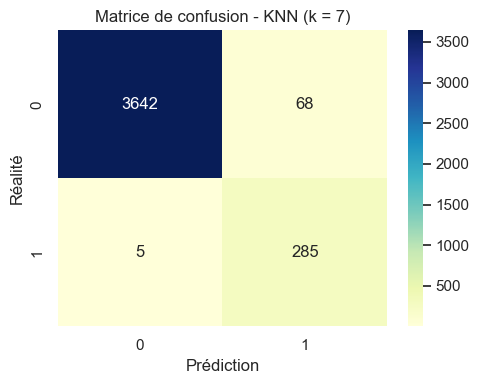

In [236]:
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion - KNN (k = 7)")
plt.tight_layout()
plt.show()


### Interprétation

Le déséquilibre de la variables is_healthy  explique en grande partie les accuracy très élevées des modèles. En effet, un modèle très simple pourrait atteindre 92 % d’accuracy simplement en prédisant toujours la classe 0, sans jamais apprendre quoi que ce soit sur les personnes healthy. Même si les modèles testés (KNN, RandomForest, DecisionTree, SVM, LogReg) semblent obtenir des scores entre 92 % et 98 %, ces valeurs ne reflètent pas réellement leur capacité à reconnaître les personnes “healthy”. 
Un modèle peut :
être très bon sur la classe majoritaire (0),
être mauvais sur la classe minoritaire (1),
mais afficher quand même une accuracy élevée.
C’est ce que révèle la distribution de la cible : la majorité écrase les performances globales.
Malgre tout on note que :

- 3642 personnes n’étaient pas en bonne santé, et le modèle l’a bien deviné.
Il a presque tout bon ici.
- 68 personnes n’étaient pas en bonne santé, mais le modèle a cru qu’elles l’étaient.
Quelques erreurs, mais pas beaucoup.
- 285 personnes étaient en bonne santé, et le modèle l’a bien reconnu.
 Très bon résultat pour celles-ci aussi.
- 5 personnes étaient en bonne santé, mais le modèle a pensé le contraire.
 C’est la plus petite erreur du modèle.

La plupart du temps, quand quelqu’un n’est pas en bonne santé, il le reconnaît.
Et quand la personne est en bonne santé, il le reconnaît aussi dans la grande majorité des cas.
Il se trompe parfois, mais ce sont de petites erreurs par rapport au nombre total de personnes testées.

## 10. Tests manuels du modèle

Pour aller plus loin qu’une simple évaluation statistique, on effectue quelques **tests manuels**.

L’objectif est de :
- simuler des profils réels,
- voir comment le KNN réagit,
- vérifier si les prédictions sont cohérentes d’un point de vue logique.

On crée donc plusieurs cas :
- un profil “healthy”
- un profil “non healthy”
- un profil borderline
- un profil incohérent (pour vérifier la robustesse)


In [281]:
import pandas as pd

def predict_health(model,
    sugar_g, rating, cholesterol_mg, water_intake_liters,
    weight_kg, lean_mass_kg, calories, reps, expected_burn,
    session_duration_hours):

    # On construit un DataFrame avec les bons noms de colonnes
    df = pd.DataFrame([{
        'sugar_g': sugar_g,
        'rating': rating,
        'cholesterol_mg': cholesterol_mg,
        'Water_Intake (liters)': water_intake_liters,
        'Weight (kg)': weight_kg,
        'lean_mass_kg': lean_mass_kg,
        'Calories': calories,
        'Reps': reps,
        'expected_burn': expected_burn,
        'Session_Duration (hours)': session_duration_hours
    }], columns=features)  # on force l'ordre des colonnes

    # Prédiction + proba
    prediction = model.predict(df)[0]
    proba = model.predict_proba(df)[0][1]

    label_mapping = {1: "Healthy ", 0: "Not Healthy "}

    print("===== PREDICTION SANTÉ =====")
    print(f"État de santé prédit : {label_mapping.get(prediction, 'Inconnu')} (classe {prediction})")
    print(f"Probabilité d'être healthy : {proba*100:.2f}%")


In [263]:
predict_health(
    knn_pipe,
    14.48, 2.01, 80.47, 2.81, 46.20, 35.420708, 1425.0, 18.91, 1000, 1.36
)


===== PREDICTION SANTÉ =====
État de santé prédit : Healthy ✔️ (classe 1)
Probabilité d'être healthy : 71.43%


## 12. Conclusion (version simple, avec KNN)

- On a construit plusieurs modèles pour prédire si une personne est **en bonne santé (`is_healthy = 1`) ou non (`0`)**.
- Après comparaison, c’est le **KNN (K-Plus Proches Voisins)** avec `k = 7` qui donne les **meilleurs résultats** sur les données de test.
- Concrètement, le modèle regarde les profils les plus proches (n termes de sucre consommé, calories, cholestérol, quantité d’eau bue, poids, masse maigre, durée d'entraînement, nombre de répétitions et calories que l’on s’attend à brûler) et décide en fonction de la majorité :
  > "Dis-moi à qui tu ressembles, je te dirai si tu es en bonne santé."

- La matrice de confusion montre :
  - combien de personnes en bonne santé sont correctement reconnues,
  - combien de personnes non saines sont correctement détectées,
  - et où se situent les erreurs.

- La **courbe ROC** et l’**AUC** permettent de voir que le KNN arrive **plutôt bien à séparer** les deux groupes (sain vs non sain).

- L’analyse par importance par permutation montre que les variables les plus influentes pour prédire is_healthy dans ce modèle KNN sont notamment :
* les variables alimentaires, comme : sugar_g (quantité de sucre consommée), cholesterol_mg, calories.
  
* les variables liées à l’hydratation et au poids, comme :water_intake_liters, weight_kg et lean_mass_kg

* les variables liées à l’activité physique, comme : session_duration_hours, expected_burn, reps

* une variable comportementale : rating (notation subjective)

En résumé :

> On obtient un modèle KNN qui exploite la ressemblance entre individus pour prédire l’état de santé.  
> Ce modèle n’est pas trop parfait, mais il donne une **base solide** pour repérer les profils à risque et peut servir d’outil d’aide à la décision.
